In [27]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

In [28]:
label = 'T0.71_N7_RHO0.844'

In [29]:
data = pd.read_csv(f'../output_files/{label}_positions_data.txt', sep=' ', names=['particle', 'time', 'x', 'y', 'z'])

In [30]:
max_steps_per_particle = data.groupby('particle')['time'].count().min()

In [32]:
# Calculate MSD for different shifts
shifted_msds = []

for shift in np.arange(0, max_steps_per_particle, 100):
    # Get the initial positions for each particle after the shift
    initial_positions = data.groupby('particle').nth(shift)[['x', 'y', 'z']]
    
    # Only consider data where we have enough future steps
    valid_data = data.groupby('particle').filter(lambda x: len(x) > shift)
    
    # Merge initial positions after the shift back to the main DataFrame
    shifted_data = valid_data.merge(initial_positions.rename(columns={'x': 'initial_x', 'y': 'initial_y', 'z': 'initial_z'}),
                                    left_on='particle', right_index=True, suffixes=('', '_initial'))
    
    # Calculate the squared displacement for each particle at each time point after the shift
    shifted_data['squared_displacement'] = (
        (shifted_data['x'] - shifted_data['initial_x'])**2 +
        (shifted_data['y'] - shifted_data['initial_y'])**2 +
        (shifted_data['z'] - shifted_data['initial_z'])**2
    )
    
    # Group by time and calculate the mean squared displacement for this shift
    msd_for_shift = shifted_data.groupby('time')['squared_displacement'].mean()
    
    # Add to the list of MSDs for different shifts
    shifted_msds.append(msd_for_shift)

# Combine MSDs from all shifts and calculate the mean
all_shifts_msd = pd.concat(shifted_msds, axis=1)
mean_msd = all_shifts_msd.mean(axis=1).reset_index(name='msd')

# Output or plot the mean_msd DataFrame
print(mean_msd)

          time        msd
0        0.010   0.000000
1        0.015   0.100969
2        0.020   0.101564
3        0.030   0.103842
4        0.040   0.107277
...        ...        ...
24128  241.285  70.361474
24129  241.295  70.189660
24130  241.305  70.190164
24131  241.315  70.190628
24132  241.325  70.248860

[24133 rows x 2 columns]


In [36]:
msd_results_ = mean_msd[mean_msd.time > 100]

In [37]:
dimension = 3
slope, intercept, r_value, p_value, std_err = stats.linregress(msd_results_['time'], msd_results_['msd'])
diffusion_constant = slope / (2 * dimension)

print("D:", diffusion_constant)
print("Slope:", slope)
print("Intercept:", intercept)
print("R-squared:", r_value**2)

D: 0.014908731583214459
Slope: 0.08945238949928676
Intercept: 48.1194944667964
R-squared: 0.9580994249731553


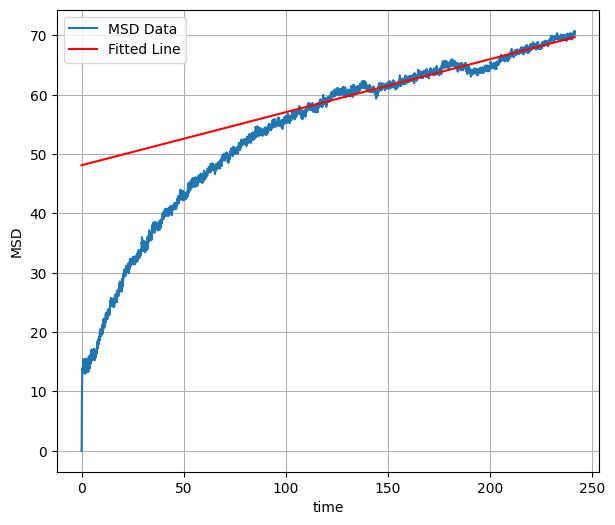

In [38]:
plt.figure(figsize=(7, 6))  

plt.plot(mean_msd.time, mean_msd.msd, label='MSD Data')
plt.plot(mean_msd['time'], intercept + slope * mean_msd['time'], 'r', label='Fitted Line')

plt.xlabel('time')
plt.ylabel('MSD')

plt.legend()
plt.grid()
plt.show()